#Cifar-10 이미지 분류 ver2
- 데이터 부풀리기 적용 

1. 데이터 전처리

In [13]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [14]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [16]:
# X_data: scaling
X_train = X_train/255.
X_test = X_test/255.

In [17]:
# y_data: one-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

2. 모델 정의/설정

In [18]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [19]:
model = Sequential([
                    Conv2D(32, (3,3), input_shape=X_train.shape[1:], padding='same', activation='relu') , # X_train.shape = (50000, 32, 32, 3)
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(), 
                    Dropout(0.25),
                    Conv2D(64, (3,3), padding='same', activation='relu'),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(), 
                    Dropout(0.25),
                    # Fully Connected Network
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.5),
                    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

In [20]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), 
    loss='categorical_crossentropy', metrics=['accuracy']
)

In [21]:
model_path = 'best-cifar10-v1.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)
# 여기까지 동일 

3. 데이터 부풀리기

In [22]:
#hist = model.fit(
#    X_train, Y_train, validation_split=0.2,
#    epochs=100, batch_size=32, callbacks=[mc,es]
#)
# 데이터 부풀리기 대상: X_train, Y_train
#-> validation_split -> 따로!

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,      # randomly rotate images in the range 15 degree
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    shear_range=0.1,         # 도형의 기울기
    zoom_range=[0.8, 1.2],  # 0.8~1.5 크기로 임의로 확대/축소  
    horizontal_flip=True,   # randomly flip images
    vertical_flip=False,    # randomly flip images
    fill_mode='nearest'     # set mode for filling points outside the input boundaries
)

In [25]:
datagen.fit(X_train)

4. 데이터 부풀리기한 결과로 학습

In [26]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid),
    epochs=100, callbacks=[mc, es]
)

Epoch 1/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.8995 - accuracy: 0.2978
Epoch 1: val_loss improved from inf to 1.64936, saving model to best-cifar10-v1.h5
1250/1250 [==============================] - 35s 19ms/step - loss: 1.8994 - accuracy: 0.2978 - val_loss: 1.6494 - val_accuracy: 0.4033
Epoch 2/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.6456 - accuracy: 0.3938
Epoch 2: val_loss improved from 1.64936 to 1.48027, saving model to best-cifar10-v1.h5
1250/1250 [==============================] - 26s 21ms/step - loss: 1.6457 - accuracy: 0.3937 - val_loss: 1.4803 - val_accuracy: 0.4667
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5465 - accuracy: 0.4357
Epoch 3: val_loss improved from 1.48027 to 1.38382, saving model to best-cifar10-v1.h5
1250/1250 [==============================] - 28s 23ms/step - loss: 1.5465 - accuracy: 0.4357 - val_loss: 1.3838 - val_accuracy: 0.5011
Epoch 4/100
1250/1250 [==================

In [27]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6965 - accuracy: 0.7669


[0.6965088248252869, 0.7669000029563904]

In [28]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs =np.arange(1, len(y_acc)+1) # 시작을 1번부터 해주기 위해서

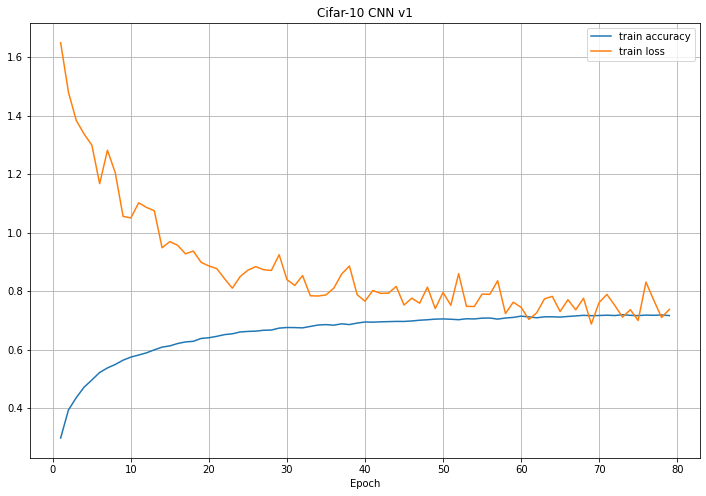

In [29]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='train loss')
plt.legend(), plt.grid(), #ylimt(0,2),
plt.xlabel('Epoch')
plt.title('Cifar-10 CNN v1')
plt.show()